In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 4070



image 1/1 c:\Users\teunm\OneDrive\Desktop\Suemy\GroupProjectSem3\SchoolProject\test\not.jpg: 384x640 1 S1_AxisNotZero, 3.4ms
Speed: 0.7ms preprocess, 3.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


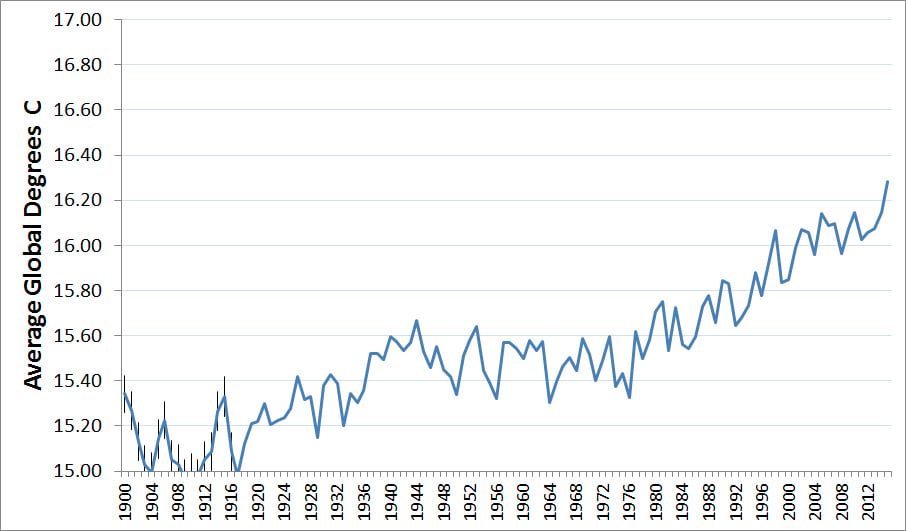

['S1_AxisNotZero']
Status: Non-Compliant


In [4]:
from ultralytics import YOLO
from pathlib import Path
from IPython.display import Image, display

yolo = YOLO("runs/detect/ibcs_v2/weights/best.pt")
results = yolo("test/not.jpg")

detections = []
for r in results:
    image_name = Path(r.path).name
    for box in r.boxes:
        label = r.names[int(box.cls)]
        confidence = float(box.conf)
        detections.append(label)
        # use the full path returned in r.path so the file is found
        display(Image(filename=str(r.path)))
        continue

print(detections)

if "OK_NoIssue" in detections and len(detections) == 1:
    status = "Compliant"
else:
    status = "Non-Compliant"
print("Status:", status)

In [5]:
issues_text = ", ".join(detections)
print("Issues detected:", issues_text)

Issues detected: S1_AxisNotZero


In [6]:
# %pip install transformers


In [7]:
import transformers
print(transformers.__version__)


c:\Users\teunm\anaconda3\envs\yolo-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.57.3


In [8]:
# %pip install accelerate
# %pip install bitsandbytes


In [9]:
# import torch
# from transformers import pipeline
# from PIL import Image

# vlm = pipeline(
#     task="image-text-to-text",
#     model="llava-hf/llava-v1.6-mistral-7b-hf",
#     torch_dtype=torch.float16,
#     load_in_4bit=True,
#     device_map="auto"
# )

# img = Image.open("test/not.jpg")

# messages = [
#     {"role": "user", "content": [
#         {"type": "text", "text": "Describe this image"},
#         {"type": "image", "image": img}
#     ]}
# ]

# print(vlm(messages))


In [14]:
import torch
from transformers import pipeline
from PIL import Image

vlm = pipeline(
    task="image-text-to-text",
    model="llava-hf/llava-v1.6-mistral-7b-hf",
    dtype=torch.bfloat16,
    device_map="auto", 
    load_in_4bit=True
)

img = Image.open("test/not.jpg")

messages = [
  {
    "role": "user",
    "content": [
      {"type": "image", "image": img},
      {
        "type": "text",
        "text": f"""
You are an IBCS compliance assistant.

Detected issues from rule engine: {issues_text}

Tasks:
1. Say whether this dashboard is compliant or non-compliant.
2. Explain the problem briefly.
3. Provide a clear recommendation using IBCS rules.

Please respond in this exact multi-line format:

Status:
Issue:
Recommendation:

Do not put everything on one line.
Do not return JSON.
"""
      }
    ]
  }
]

# Return JSON ONLY:
# {{ 
#  "status": "",
#  "issues": [],
#  "recommendations": []
# }}

response = vlm(messages, max_new_tokens=250)
print(response[0]["generated_text"])


Loading checkpoint shards: 100%|██████████| 4/4 [00:15<00:00,  3.83s/it]
Some parameters are on the meta device because they were offloaded to the cpu.
Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'role': 'user', 'content': [{'type': 'image', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=906x531 at 0x108A71D9840>}, {'type': 'text', 'text': '\nYou are an IBCS compliance assistant.\n\nDetected issues from rule engine: S1_AxisNotZero\n\nTasks:\n1. Say whether this dashboard is compliant or non-compliant.\n2. Explain the problem briefly.\n3. Provide a clear recommendation using IBCS rules.\n\nPlease respond in this exact multi-line format:\n\nStatus:\nIssue:\nRecommendation:\n\nDo not put everything on one line.\nDo not return JSON.\n'}]}, {'role': 'assistant', 'content': ' Status: Non-compliant\nIssue: The dashboard has an axis that is not zero.\nRecommendation: To comply with IBCS rules, the axis should be set to zero. This will ensure that the chart accurately represents the data and is easier for users to interpret. '}]
